In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.misc import derivative

In [32]:
import sys
sys.path.append('/home/artem/git/sdafe-utils')

In [34]:
from sdafe.ch05.mle import mle_se, aic, bic
from sdafe.ch05.univariate import dged, dsged, dsstd

### 5.6 Generalized Error Distributions

In [35]:
xs = np.array([-5, -2, -1, 0, 1, 2, 5])

In [36]:
dged(xs, 0.5, 2, 1.5)

array([0.00629197, 0.07816905, 0.14185042, 0.2154269 , 0.2154269 ,
       0.14185042, 0.01617664])

In [37]:
dsged(xs, 0.5, 2, 1.5, 0.7)

array([0.01027024, 0.07004339, 0.11518841, 0.17287878, 0.23004985,
       0.20420655, 0.00653799])

### 5.14 Fitting Distributions by Maximum Likelihood

In [38]:
capm = pd.read_csv("../data/Capm.csv", index_col=0)
capm.head()

,rfood,rdur,rcon,rmrf,rf
1,-4.59,0.87,-6.84,-6.99,0.33
2,2.62,3.46,2.78,0.99,0.29
3,-1.67,-2.28,-0.48,-1.46,0.35
4,0.86,2.41,-2.02,-1.70,0.19
5,7.34,6.33,3.69,3.08,0.27


In [39]:
x = capm['rf'].diff().dropna()

#### Fit symmetric t-distribution

In [40]:
start = np.array([np.mean(x), np.std(x, ddof=1), 5])

In [41]:
loglik_f = lambda beta: np.sum(-np.log(stats.t.pdf((x - beta[0]) / beta[1], beta[2])) + np.log(beta[1]))

In [42]:
fit_t = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None)])
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -693.1793170655013
        x: [ 1.215e-03  4.584e-02  3.334e+00]
      nit: 20
      jac: [ 0.000e+00 -2.387e-04 -1.137e-05]
     nfev: 112
     njev: 28
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

NB the inverse Hessian approximation returned by ``scipy.optimize.minimize`` is unstable (in particular, it seems to be sensitive to the starting point).

In [43]:
fit_t.x

array([1.21472223e-03, 4.58428407e-02, 3.33396451e+00])

In [44]:
np.sqrt(np.diag(fit_t.hess_inv.todense()))

array([2.67304507e-03, 6.97907604e-03, 3.72350982e+00])

So we attempt to calculate the Hessian numerically ourselves:

In [45]:
def second_deriv(f, x0, dx):
    """Numerically approximate the second derivative using a symmetric difference"""
    return (f(x0 + dx) - 2 * f(x0) + f(x0 - dx)) / dx ** 2

In [46]:
def second_deriv_comp(f, x0, i, dx):
    """Numerically approximate the second derivative by a component of the input vector"""
    def f_mod(x):
        x0c = x0.copy()
        x0c[i] = x
        return f(x0c)
    return second_deriv(f_mod, x0[i], dx)

Plot the sensitivity of the numerically approximated derivative value to the choice of the increment:

/tmp/ipykernel_190184/817180242.py:1: RuntimeWarning: invalid value encountered in log
  loglik_f = lambda beta: np.sum(-np.log(stats.t.pdf((x - beta[0]) / beta[1], beta[2])) + np.log(beta[1]))


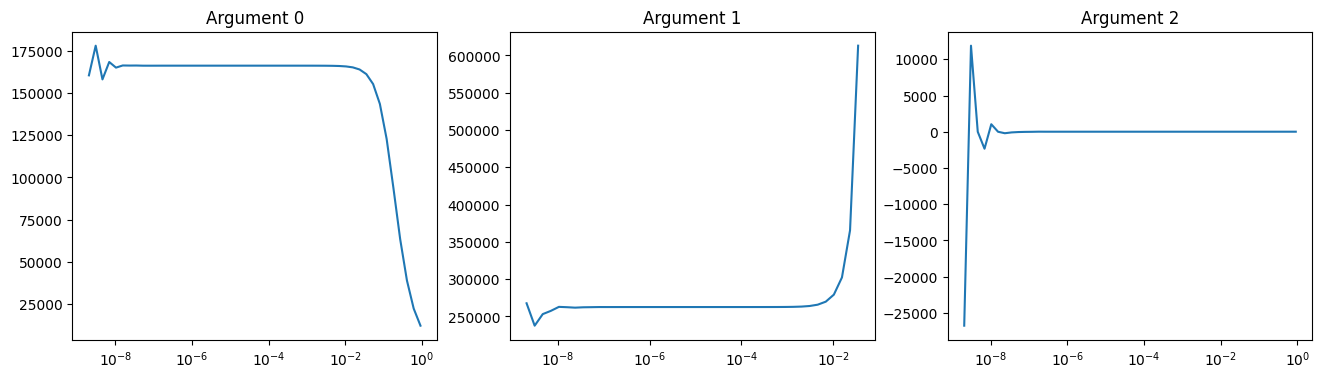

In [47]:
xs = np.exp(np.linspace(-20, -0.1))

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for i in range(len(fit_t.x)):
    d2f = lambda dx: second_deriv_comp(loglik_f, fit_t.x, i, dx)
    ys = [d2f(x) for x in xs]

    axs[i].plot(xs, ys)
    axs[i].set_xscale('log')
    axs[i].set_title(f'Argument {i}')

Calculate standard errors of the MLE estimates using the Hessian:

In [48]:
fit_t.x

array([1.21472223e-03, 4.58428407e-02, 3.33396451e+00])

In [49]:
mle_se(fit_t.x, loglik_f, 1e-6)

array([0.00245358, 0.00246146, 0.49987179])

In [50]:
aic(fit_t)

-1380.3586341310026

In [51]:
bic(fit_t, len(x))

-1367.6261334290114

Fit skewed t distribution

In [52]:
loglik_f = lambda beta: np.sum(-np.log(dsstd(x, mean=beta[0], sd=beta[1], nu=beta[2], xi=beta[3])))

In [53]:
start = np.array([np.mean(x), np.std(x, ddof=1), 5, 1])

In [54]:
fit_t = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (2.1, None), (0, None)])
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -693.1795188395072
        x: [ 1.180e-03  7.246e-02  3.336e+00  9.987e-01]
      nit: 30
      jac: [ 2.046e-04 -1.228e-03 -2.274e-05  0.000e+00]
     nfev: 180
     njev: 36
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [55]:
np.sqrt(np.diag(fit_t.hess_inv.todense()))

array([0.01795505, 0.01332224, 3.5029864 , 0.27201348])

In [56]:
mle_se(fit_t.x, loglik_f, 1e-6)

array([0.00299423, 0.00659192, 0.50778325, 0.06431231])

In [57]:
aic(fit_t)

-1378.3590376790144

In [58]:
bic(fit_t, len(x))

-1361.3823700763594